In this Notebook we want to show that our model has a tight fit to the data ...

Try to _keep it simple_ for the paper. For actual detailed predictions, refer to the progress reports (published on Research Gate)

The first couple of paragraphs here are roughly copied from `models/utils.py`'s `initialize_COVID19_SEIQRD_spatial_rescaling` function

# Load Python packages

In [7]:
import numpy as np
import os, pickle
import pandas as pd
import json
import random
import matplotlib.pyplot as plt

# Import the file with the model definitions
from covid19model.models.models import COVID19_SEIQRD_spatial_rescaling
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, \
                                                      make_contact_matrix_function, \
                                                      make_VOC_function, \
                                                      make_vaccination_rescaling_function, \
                                                      make_seasonality_function_NEW
# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.data.utils import convert_age_stratified_quantity
from covid19model.optimization.utils import samples_dict_to_emcee_chain

from covid19model.visualization.output import color_timeframes

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'prov'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 # Load necessary data

In [8]:
# Population size, interaction matrices and the model parameters
initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False, provincial=True)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data = mobility.get_proximus_mobility_data(agg)

# Variants of concern
VOCs = ['WT', 'abc', 'delta']
VOC_logistic_growth_parameters, VOC_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(initN, params['h'], VOCs=VOCs)
params.update(VOC_params)

# Load and format local vaccination-induced rescaling data, which is also under the sciensano object
rescaling_df = sciensano.get_vaccination_rescaling_values(spatial=True)


# Remove superfluous parameters from default params dict
superfluous_params = ['f_immune_escape', 'e_s', 'e_h', 'e_i', 'doses', 'd_vacc', 'N_vacc', 'daily_doses', 'delay_immunity', 'vacc_order', 'stop_idx', 'refusal', 'initN', 'default_mobility', 'onset_days']
# superfluous_params += ['amplitude', 'peak_shift']
for key in superfluous_params:
    if key in params:
        params.pop(key)

# Add new parameters (these will be time-dependent soon)
params['E_susc'] = np.ones([11, 10])
params['E_inf'] = np.ones([11, 10])
params['E_hosp'] = np.ones([11, 10])

# Add seasonality parameter
params['seasonality'] = 1

# Load time-dependent parameter functions

In [10]:
# Time-dependent social contact matrix over all policies, updating Nc
# policies used in best-fit
policy_function = make_contact_matrix_function(df_google, Nc_dict).policies_all_spatial
policy_function_work = make_contact_matrix_function(df_google, Nc_dict).policies_all_work_only

# Time-dependent mobility function, updating P (place)
mobility_function = \
    make_mobility_update_function(proximus_mobility_data).mobility_wrapper_func

# Time-dependent VOC function, updating alpha
VOC_function = make_VOC_function(VOC_logistic_growth_parameters)

# Time-dependent vaccination-induced rescaling parameter functions, updating E_susc^g, E_inf^g, E_hosp^g
E_susc_function = make_vaccination_rescaling_function(rescaling_df).E_susc
E_inf_function = make_vaccination_rescaling_function(rescaling_df).E_inf
E_hosp_function = make_vaccination_rescaling_function(rescaling_df).E_hosp

# Time-dependent seasonality function, updating season_factor
seasonality_function = make_seasonality_function_NEW()

# Define initial conditions

In [11]:
# Get correct initial condition
start_date = '2020-03-17'
age_classes = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')

samples_path = '../../data/interim/model_parameters/COVID19_SEIQRD/initial_conditions/'+agg+'/'

with open(samples_path+'initial_states-COVID19_SEIQRD_spatial.pickle', 'rb') as handle:
    load = pickle.load(handle)
    initial_states = load[start_date]
    
for key,value in initial_states.items():
    converted_value = np.zeros([value.shape[0], len(age_classes)])
    for i in range(value.shape[0]):
        column = value[i,:]
        data = pd.Series(index=age_classes, data=column)
        converted_value[i,:] = convert_age_stratified_quantity(data, age_classes).values
    initial_states.update({key: converted_value})

# Initialise models
Using the particular types of "future" time-dependent parameter functions

In [12]:

# Initiate spatial model with initial states, defined parameters, and proper time dependent functions
  
model = COVID19_SEIQRD_spatial_rescaling(initial_states, params, spatial='prov', time_dependent_parameters={'Nc' : policy_function,
                                                                                                            'Nc_work' : policy_function_work,
                                                                                                            'place' : mobility_function,
                                                                                                            'f_VOC' : VOC_function,
                                                                                                            'E_susc' : E_susc_function,
                                                                                                            'E_inf' : E_inf_function,
                                                                                                            'E_hosp' : E_hosp_function,
                                                                                                            'seasonality' : seasonality_function})
  
    
# hard-code social intertia values
model.parameters['l1'] = 14 # 21
model.parameters['l2'] = 14

# hard-code increase in hospitalisation propensity
model.parameters['K_hosp'] = np.array([1.61,1.61], np.float64)

# Define parameter dictionary and draw function

In [13]:
# Identify sampels dict (output from calibration up to the desired point)
json_name = 'prov_BASE_SAMPLES_2022-03-29.json'
json_loc = f"../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/{agg}"

# Load dict and thin/discard
samples_dict = json.load(open(f'{json_loc}/{json_name}'))
print("Keys in samples_dict: ", samples_dict.keys())
print("====================")
print("This calibration ends in", samples_dict['end_calibration'])

Keys in samples_dict:  dict_keys(['beta_R', 'beta_U', 'beta_M', 'eff_schools', 'eff_work', 'eff_rest', 'mentality', 'eff_home', 'K_inf_abc', 'K_inf_delta', 'amplitude', 'zeta', 'dispersion', 'warmup', 'n_chains', 'start_calibration', 'end_calibration'])
This calibration ends in 2021-10-01


In [14]:
# match the draw function with the available keys in the params dict
def draw_fcn(param_dict,samples_dict):
    # pick one random value from the dictionary
    idx, param_dict['beta_R'] = random.choice(list(enumerate(samples_dict['beta_R'])))
    # take out the other parameters that belong to the same iteration
    param_dict['beta_U'] = samples_dict['beta_U'][idx]
    param_dict['beta_M'] = samples_dict['beta_M'][idx]
    # param_dict['l1'] = samples_dict['l1'][idx] # hard-coded to 14
    # param_dict['l2'] = samples_dict['l2'][idx] # hard-coded to 14
    param_dict['eff_schools'] = samples_dict['eff_schools'][idx]
    param_dict['eff_work'] = samples_dict['eff_work'][idx]
    param_dict['eff_rest'] = samples_dict['eff_rest'][idx]
    param_dict['mentality'] = samples_dict['mentality'][idx]
    param_dict['eff_home'] = samples_dict['eff_home'][idx]
    param_dict['K_inf'] = np.array([samples_dict['K_inf_abc'][idx], samples_dict['K_inf_delta'][idx]], np.float64)
    # param_dict['K_inf'] = np.array([samples_dict['K_inf_abc'][idx], samples_dict['K_inf_abc'][idx]], np.float64)
    param_dict['amplitude'] = samples_dict['amplitude'][idx]
    param_dict['zeta'] = samples_dict['zeta'][idx]
    return param_dict

# Make simulation

**Question**! Shouldn't we als thin out the param dict when we sample this making time series?

In [77]:
start_date = samples_dict['start_calibration']
end_date = pd.Timestamp(2022, 1, 1) # samples_dict['end_calibration']to be changed

warmup = int(samples_dict['warmup'])

# remove amplitude
# if 'amplitude' in samples_dict:
#     samples_dict.pop('amplitude')

N = 100 # number of simulations with independent draws from the posterior of the sampled parameter values

out = model.sim(end_date, start_date=start_date, warmup=warmup, N=N, \
                draw_fcn=draw_fcn, samples=samples_dict, verbose=True)

# Make graphs

## Make corner plot

See `notebooks/calibration/MR-postprocessing-calibration.ipynb`

## Load Sciensano data

In [57]:
from covid19model.data import sciensano
public_spatial_hosp_df = sciensano.get_sciensano_COVID19_data_spatial(agg=agg, values='hospitalised_IN', moving_avg=False, public=True)

## Plot national and regional daily new hospitalisations

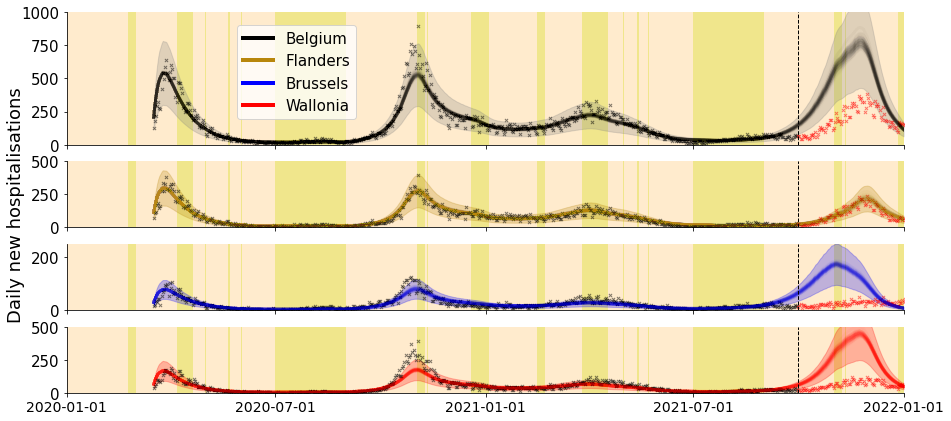

In [80]:
fig, axs = plt.subplots(4,1, figsize=(15,7), gridspec_kw={'height_ratios': [2, 1, 1, 1]}, sharex=True)

# Background
start_background = pd.Timestamp(2020, 1, 1)
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
for i in range(4):
    color_timeframes(start_background, end_date, ax=axs[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

### Simulations

values_national = out['H_in'].sum(dim='place').sum(dim='Nc').values
scatter_national = public_spatial_hosp_df.sum(axis=1)

NIS_flanders = [10000, 20001, 40000, 30000, 70000]
values_flanders = 0
scatter_flanders = 0
for NIS in NIS_flanders:
    values_flanders += out['H_in'].sel(place=NIS).sum(dim='Nc').values
    scatter_flanders += public_spatial_hosp_df[NIS].values
    
NIS_wallonia = [20002, 50000, 60000, 80000, 90000]
values_wallonia = 0
scatter_wallonia = 0
for NIS in NIS_wallonia:
    values_wallonia += out['H_in'].sel(place=NIS).sum(dim='Nc').values
    scatter_wallonia += public_spatial_hosp_df[NIS].values
    
values_brussels = out['H_in'].sel(place=21000).sum(dim='Nc').values
scatter_brussels = public_spatial_hosp_df[21000].values

# Negative binomial errors
dispersal = sigma = np.median(samples_dict['dispersion'])
errors_national = np.sqrt(np.mean(values_national,axis=0) + np.mean(values_national,axis=0)**2*dispersal)
errors_flanders = np.sqrt(np.mean(values_flanders,axis=0) + np.mean(values_flanders,axis=0)**2*dispersal)
errors_wallonia = np.sqrt(np.mean(values_wallonia,axis=0) + np.mean(values_wallonia,axis=0)**2*dispersal)
errors_brussels = np.sqrt(np.mean(values_brussels,axis=0) + np.mean(values_brussels,axis=0)**2*dispersal)

dates = out.time.values
scatter_dates = public_spatial_hosp_df.index
N = values_national.shape[0]

alpha_rescale = 1 
linewidth = 1
error_alpha = 0.25

color_national = 'black'
color_flanders = 'darkgoldenrod'
color_brussels = 'blue'
color_wallonia = 'red'

axs[0].plot(dates, values_national[0], color=color_national, alpha=alpha_rescale/N, label='Belgium', linewidth=linewidth)
axs[0].fill_between(dates, np.median(values_national,axis=0) + errors_national, \
                np.median(values_national,axis=0) - errors_national, color='grey', alpha=error_alpha)

axs[1].plot(dates, values_flanders[0], color=color_flanders, alpha=alpha_rescale/N, label='Flanders', linewidth=linewidth)
axs[1].fill_between(dates, np.median(values_flanders,axis=0) + errors_flanders, \
                np.median(values_flanders,axis=0) - errors_flanders, color=color_flanders, alpha=error_alpha)

axs[2].plot(dates, values_brussels[0], color=color_brussels, alpha=alpha_rescale/N, label='Brussels', linewidth=linewidth)
axs[2].fill_between(dates, np.median(values_brussels,axis=0) + errors_brussels, \
                np.median(values_brussels,axis=0) - errors_brussels, color=color_brussels, alpha=error_alpha)

axs[3].plot(dates, values_wallonia[0], color=color_wallonia, alpha=alpha_rescale/N, label='Wallonia', linewidth=linewidth)
axs[3].fill_between(dates, np.median(values_wallonia,axis=0) + errors_wallonia, \
                np.median(values_wallonia,axis=0) - errors_wallonia, color=color_wallonia, alpha=error_alpha)

for i in range(1,N):
    axs[0].plot(dates, values_national[i], color=color_national, alpha=alpha_rescale/N)
    axs[1].plot(dates, values_flanders[i], color=color_flanders, alpha=alpha_rescale/N)
    axs[2].plot(dates, values_brussels[i], color=color_brussels, alpha=alpha_rescale/N)
    axs[3].plot(dates, values_wallonia[i], color=color_wallonia, alpha=alpha_rescale/N)

ticklabelsize=14
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 7, 1).date(), \
        pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2022, 1, 1).date()]

leg_position = (0.4, 0.87)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
leg = fig.legend(lines, labels, bbox_to_anchor=(leg_position[0], leg_position[1]))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(4)

for i in range(4):
    axs[i].set_title(None)
    axs[i].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
    axs[i].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xlabel(None)
    axs[i].grid(False)
    axs[i].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)
    
fig.supylabel('Daily new hospitalisations', x=0.07)

# Scatter data
idx_first_cal = [idx for idx, date in enumerate(scatter_dates) if date >= pd.Timestamp(samples_dict['start_calibration'])][0]
idx_final_cal = [idx for idx, date in enumerate(scatter_dates) if date <= pd.Timestamp(samples_dict['end_calibration'])][-1]
color_cal = 'k'
color_future = 'r'
scatter_alpha = 0.5
scatter_size = 10

axs[0].scatter(scatter_dates[idx_first_cal:idx_final_cal], scatter_national[idx_first_cal:idx_final_cal], \
               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=scatter_alpha)
axs[0].scatter(scatter_dates[idx_final_cal:], scatter_national[idx_final_cal:], \
               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=scatter_alpha)

axs[1].scatter(scatter_dates[idx_first_cal:idx_final_cal], scatter_flanders[idx_first_cal:idx_final_cal], \
               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=scatter_alpha)
axs[1].scatter(scatter_dates[idx_final_cal:], scatter_flanders[idx_final_cal:], \
               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=scatter_alpha)

axs[2].scatter(scatter_dates[idx_first_cal:idx_final_cal], scatter_brussels[idx_first_cal:idx_final_cal], \
               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=scatter_alpha)
axs[2].scatter(scatter_dates[idx_final_cal:], scatter_brussels[idx_final_cal:], \
               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=scatter_alpha)

axs[3].scatter(scatter_dates[idx_first_cal:idx_final_cal], scatter_wallonia[idx_first_cal:idx_final_cal], \
               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=scatter_alpha)
axs[3].scatter(scatter_dates[idx_final_cal:], scatter_wallonia[idx_final_cal:], \
               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=scatter_alpha)

axs[0].set_ylim([0, 1000])
axs[1].set_ylim([0, 500])
axs[2].set_ylim([0, 250])
axs[3].set_ylim([0, 500])

# plt.savefig("national-and-regional-complete-model-fit.png", dpi=800, bbox_inches='tight')

## Plot provincial daily new hospitalisations (appendix)

## Plot recovered compartment and seroprevalence data

In [89]:
# Get raw national Herzog and Sciensano seroprevalence data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
scatter_herzog = df_sero_herzog['abs']['mean'].values
scatter_sciensano = df_sero_sciensano['abs']['mean'].values

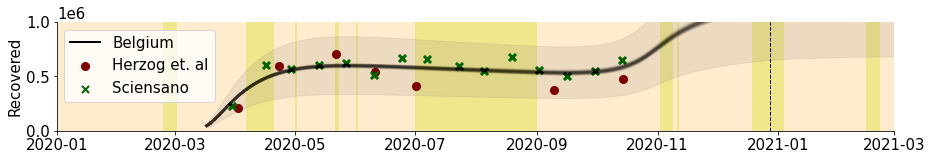

In [112]:
fig, ax = plt.subplots(figsize=(15,2))

# Background
start_background = pd.Timestamp(2020, 1, 1)
week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_background, end_date, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

### Simulations

values_sero = out['R'].sum(dim='place').sum(dim='Nc').values

# Negative binomial errors
dispersal = sigma = np.median(samples_dict['dispersion'])
errors_sero = np.sqrt(np.mean(values_national,axis=0) + np.mean(values_national,axis=0)**2*dispersal)

dates = out.time.values
scatter_dates_herzog = df_sero_herzog.index
scatter_dates_sciensano = df_sero_sciensano.index
N = values_national.shape[0]

alpha_rescale = 1 
linewidth = 1
error_alpha = 0.15

color_national = 'black'

ax.plot(dates, values_sero[0], color=color_national, alpha=alpha_rescale/N, label='Belgium', linewidth=linewidth)
ax.fill_between(dates, np.median(values_sero,axis=0) + errors_national, \
                np.median(values_sero,axis=0) - errors_national, color='grey', alpha=error_alpha)

for i in range(1,N):
    ax.plot(dates, values_sero[i], color=color_national, alpha=alpha_rescale/N)
    
# Scatter data
color_herzog = 'maroon'
color_sciensano = 'darkgreen'
scatter_alpha = 1
scatter_size = 50

ax.scatter(scatter_dates_herzog, scatter_herzog, \
               s=scatter_size, color=color_herzog, marker='o', linewidth=2, alpha=scatter_alpha, label='Herzog et. al')
ax.scatter(scatter_dates_sciensano, scatter_sciensano, \
               s=scatter_size, color=color_sciensano, marker='x', linewidth=3, alpha=scatter_alpha, label='Sciensano')

leg = ax.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(2)

ax.set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2021, 3, 1)])
ax.set_ylim([0, 1e6])
ax.set_ylabel('Recovered')
ax.axvline(pd.Timestamp(2020, 12, 28), linestyle='--', color='k', linewidth=1)
ax.grid(False)

# plt.savefig("seroprevalence-spatial-fit.png", dpi=800, bbox_inches='tight')